In [54]:
import tensorflow as tf
from tensorflow import train
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Dropout, Dense, Softmax)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import mobilenet as _mobilenet
from keras_tqdm import TQDMNotebookCallback
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import PIL



In [55]:
#Helper Functions
def load_image(img_file, target_size = (224,224)):
    X = np.zeros((1,*target_size, 3))
    X[0, ] = np.asarray(tf.keras.preprocessing.image.load_img(
        img_file,
        target_size = target_size)
    )
    X = tf.keras.applications.mobilenet.preprocess_input(X)
    return X

def ensure_folder_exists(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)



In [56]:
model = tf.keras.applications.mobilenet.MobileNet()
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [57]:
sedan_image_id = os.listdir('CarImages/Sedan')[0]
sedan_image = load_image((os.path.join('CarImages/Sedan', sedan_image_id)))

print(f'shape: {sedan_image.shape}')
print(f'type: {type(sedan_image)}')

model.predict(sedan_image)

shape: (1, 224, 224, 3)
type: <class 'numpy.ndarray'>


array([[3.49633240e-07, 6.62355362e-08, 7.76521290e-07, 1.95531766e-06,
        1.34502216e-05, 1.49900825e-06, 6.35915072e-08, 4.08038794e-08,
        2.70185812e-08, 2.79546327e-07, 2.66742660e-07, 3.50595542e-07,
        7.63463902e-07, 9.52963433e-08, 1.42148835e-07, 5.02430566e-07,
        7.74720519e-08, 7.30571088e-08, 9.45561396e-07, 1.91560298e-06,
        1.06551761e-06, 6.27927511e-05, 1.84335795e-06, 3.87171349e-06,
        6.62684533e-06, 2.26725199e-08, 4.07014369e-08, 2.09278177e-08,
        4.23027245e-07, 2.20624408e-08, 2.51567229e-08, 4.51074982e-08,
        8.10480174e-07, 1.53898867e-07, 1.04532523e-06, 1.09479697e-06,
        1.34665663e-06, 1.32371866e-07, 6.00663498e-07, 5.49014203e-07,
        1.35364246e-07, 1.94604937e-08, 1.52303521e-08, 1.70419412e-07,
        4.32365539e-08, 4.51066384e-08, 1.50256554e-07, 1.16546026e-07,
        4.97141883e-09, 3.14933346e-09, 3.33203758e-08, 3.18673358e-07,
        3.66995835e-07, 1.68313221e-07, 1.41770101e-06, 2.733868

In [58]:
#Loading MobileNet model for transfer learning
model = tf.keras.applications.mobilenet.MobileNet(
    input_shape = (224,224,3),
    include_top = False,
    pooling = 'avg'
    )


In [59]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [60]:
x = Dropout(rate = 0.4)(model.output) #Removes nodes during training to prevent overfitting
x = Dense(2)(x) #Fully connected layer
x = Softmax()(x) #Function which specifies output value
model = Model(model.inputs, x)


In [61]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [62]:
#Transfer learning being applied here, only top 3 layers are retrained
#Specifying the model layers that need to be retrained
for layer in model.layers[:-3]:
    layer.trainable = False
    

In [63]:
#Compiling the Model
model.compile(
    optimizer = Adam(lr=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True))

In [64]:
#Modifying images in order to have each the same size and shape
#This is the data generator
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = _mobilenet.preprocess_input,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    validation_split = 0.2)



In [65]:
ensure_folder_exists('training_aug')

training_data = datagen.flow_from_directory(
    'CarImages',
    target_size = (224,224),
    save_to_dir = './training_aug',
    subset = 'training'
    )

ensure_folder_exists('validation_aug')

#Validation Data
validation_dat = datagen.flow_from_directory(
    'CarImages',
    target_size = (224,224),
    save_to_dir = './validation_aug',
    subset = 'validation'
    )


Found 596 images belonging to 2 classes.
Found 149 images belonging to 2 classes.


In [66]:
#Train the model

batch_size = 32

image_classifier_model = model.fit_generator(
    generator = training_data,
    steps_per_epoch = training_data.samples // batch_size,
    epochs = 70,
    callbacks = [TQDMNotebookCallback(leave_inner = True, leave_outer = True)],
    validation_data = validation_dat,
    validation_steps = validation_dat.samples // batch_size
)


Epoch 1/70
18/18 [==============================] - ETA: 5:21 - loss: 0.691 - ETA: 4:13 - loss: 0.697 - ETA: 3:29 - loss: 0.712 - ETA: 2:54 - loss: 0.708 - ETA: 2:37 - loss: 0.720 - ETA: 2:23 - loss: 0.716 - ETA: 2:05 - loss: 0.723 - ETA: 1:49 - loss: 0.726 - ETA: 1:40 - loss: 0.726 - ETA: 1:27 - loss: 0.722 - ETA: 1:14 - loss: 0.719 - ETA: 1:02 - loss: 0.720 - ETA: 52s - loss: 0.718 - ETA: 40s - loss: 0.71 - ETA: 29s - loss: 0.71 - ETA: 20s - loss: 0.71 - ETA: 9s - loss: 0.7160 - 193s 11s/step - loss: 0.7176 - val_loss: 0.7139


Epoch 2/70
18/18 [==============================] - ETA: 2:27 - loss: 0.732 - ETA: 2:18 - loss: 0.711 - ETA: 2:09 - loss: 0.720 - ETA: 1:58 - loss: 0.716 - ETA: 1:49 - loss: 0.717 - ETA: 1:41 - loss: 0.717 - ETA: 1:36 - loss: 0.724 - ETA: 1:32 - loss: 0.721 - ETA: 1:24 - loss: 0.720 - ETA: 1:13 - loss: 0.722 - ETA: 1:06 - loss: 0.719 - ETA: 57s - loss: 0.714 - ETA: 48s - loss: 0.71 - ETA: 38s - loss: 0.71 - ETA: 29s - loss: 0.71 - ETA: 19s - loss: 0.71 - ETA: 9s - loss: 0.7184 - 177s 10s/step - loss: 0.7172 - val_loss: 0.6849


Epoch 3/70
18/18 [==============================] - ETA: 2:25 - loss: 0.669 - ETA: 2:18 - loss: 0.662 - ETA: 2:16 - loss: 0.680 - ETA: 2:07 - loss: 0.680 - ETA: 2:04 - loss: 0.667 - ETA: 1:54 - loss: 0.665 - ETA: 1:44 - loss: 0.665 - ETA: 1:34 - loss: 0.669 - ETA: 1:24 - loss: 0.674 - ETA: 1:13 - loss: 0.668 - ETA: 1:03 - loss: 0.671 - ETA: 53s - loss: 0.675 - ETA: 44s - loss: 0.67 - ETA: 34s - loss: 0.68 - ETA: 26s - loss: 0.67 - ETA: 17s - loss: 0.68 - ETA: 8s - loss: 0.6822 - 164s 9s/step - loss: 0.6803 - val_loss: 0.6675


Epoch 4/70
18/18 [==============================] - ETA: 2:31 - loss: 0.707 - ETA: 1:59 - loss: 0.713 - ETA: 1:59 - loss: 0.697 - ETA: 1:53 - loss: 0.691 - ETA: 1:50 - loss: 0.693 - ETA: 1:44 - loss: 0.688 - ETA: 1:38 - loss: 0.680 - ETA: 1:29 - loss: 0.676 - ETA: 1:22 - loss: 0.678 - ETA: 1:16 - loss: 0.678 - ETA: 1:06 - loss: 0.676 - ETA: 56s - loss: 0.677 - ETA: 46s - loss: 0.67 - ETA: 36s - loss: 0.67 - ETA: 27s - loss: 0.67 - ETA: 18s - loss: 0.67 - ETA: 9s - loss: 0.6765 - 173s 10s/step - loss: 0.6732 - val_loss: 0.6584


Epoch 5/70
18/18 [==============================] - ETA: 2:08 - loss: 0.685 - ETA: 1:36 - loss: 0.668 - ETA: 1:48 - loss: 0.670 - ETA: 1:53 - loss: 0.668 - ETA: 1:53 - loss: 0.659 - ETA: 1:45 - loss: 0.660 - ETA: 1:36 - loss: 0.657 - ETA: 1:33 - loss: 0.652 - ETA: 1:27 - loss: 0.654 - ETA: 1:17 - loss: 0.652 - ETA: 1:07 - loss: 0.653 - ETA: 57s - loss: 0.655 - ETA: 48s - loss: 0.65 - ETA: 37s - loss: 0.65 - ETA: 27s - loss: 0.66 - ETA: 18s - loss: 0.66 - ETA: 9s - loss: 0.6632 - 177s 10s/step - loss: 0.6657 - val_loss: 0.6532


Epoch 6/70
18/18 [==============================] - ETA: 2:17 - loss: 0.682 - ETA: 2:03 - loss: 0.665 - ETA: 2:01 - loss: 0.651 - ETA: 1:55 - loss: 0.656 - ETA: 1:51 - loss: 0.654 - ETA: 1:48 - loss: 0.652 - ETA: 1:42 - loss: 0.644 - ETA: 1:32 - loss: 0.649 - ETA: 1:23 - loss: 0.648 - ETA: 1:13 - loss: 0.648 - ETA: 1:04 - loss: 0.649 - ETA: 55s - loss: 0.653 - ETA: 45s - loss: 0.65 - ETA: 36s - loss: 0.65 - ETA: 26s - loss: 0.65 - ETA: 18s - loss: 0.65 - ETA: 9s - loss: 0.6520 - 173s 10s/step - loss: 0.6515 - val_loss: 0.6501


Epoch 7/70
18/18 [==============================] - ETA: 2:30 - loss: 0.695 - ETA: 2:11 - loss: 0.684 - ETA: 2:00 - loss: 0.678 - ETA: 1:55 - loss: 0.669 - ETA: 1:49 - loss: 0.656 - ETA: 1:35 - loss: 0.663 - ETA: 1:31 - loss: 0.660 - ETA: 1:22 - loss: 0.656 - ETA: 1:15 - loss: 0.650 - ETA: 1:04 - loss: 0.647 - ETA: 57s - loss: 0.644 - ETA: 49s - loss: 0.64 - ETA: 41s - loss: 0.65 - ETA: 33s - loss: 0.65 - ETA: 25s - loss: 0.65 - ETA: 16s - loss: 0.64 - ETA: 8s - loss: 0.6517 - 160s 9s/step - loss: 0.6509 - val_loss: 0.6536


Epoch 8/70
18/18 [==============================] - ETA: 2:07 - loss: 0.648 - ETA: 2:08 - loss: 0.621 - ETA: 1:58 - loss: 0.628 - ETA: 1:54 - loss: 0.638 - ETA: 1:47 - loss: 0.637 - ETA: 1:42 - loss: 0.640 - ETA: 1:38 - loss: 0.639 - ETA: 1:33 - loss: 0.635 - ETA: 1:24 - loss: 0.636 - ETA: 1:14 - loss: 0.636 - ETA: 1:04 - loss: 0.636 - ETA: 56s - loss: 0.637 - ETA: 46s - loss: 0.63 - ETA: 37s - loss: 0.63 - ETA: 27s - loss: 0.63 - ETA: 18s - loss: 0.63 - ETA: 8s - loss: 0.6398 - 171s 10s/step - loss: 0.6399 - val_loss: 0.6400


Epoch 9/70
18/18 [==============================] - ETA: 2:13 - loss: 0.593 - ETA: 2:06 - loss: 0.623 - ETA: 2:07 - loss: 0.643 - ETA: 1:54 - loss: 0.642 - ETA: 1:44 - loss: 0.646 - ETA: 1:34 - loss: 0.648 - ETA: 1:29 - loss: 0.644 - ETA: 1:22 - loss: 0.638 - ETA: 1:11 - loss: 0.640 - ETA: 1:04 - loss: 0.640 - ETA: 56s - loss: 0.638 - ETA: 50s - loss: 0.63 - ETA: 41s - loss: 0.64 - ETA: 33s - loss: 0.63 - ETA: 25s - loss: 0.64 - ETA: 17s - loss: 0.63 - ETA: 8s - loss: 0.6419 - 163s 9s/step - loss: 0.6429 - val_loss: 0.6406


Epoch 10/70
18/18 [==============================] - ETA: 2:28 - loss: 0.629 - ETA: 2:28 - loss: 0.660 - ETA: 2:12 - loss: 0.653 - ETA: 1:59 - loss: 0.654 - ETA: 1:50 - loss: 0.645 - ETA: 1:43 - loss: 0.645 - ETA: 1:33 - loss: 0.642 - ETA: 1:24 - loss: 0.650 - ETA: 1:16 - loss: 0.649 - ETA: 1:08 - loss: 0.644 - ETA: 1:00 - loss: 0.647 - ETA: 52s - loss: 0.641 - ETA: 44s - loss: 0.64 - ETA: 35s - loss: 0.64 - ETA: 26s - loss: 0.64 - ETA: 17s - loss: 0.63 - ETA: 8s - loss: 0.6382 - 173s 10s/step - loss: 0.6393 - val_loss: 0.6335


Epoch 11/70
18/18 [==============================] - ETA: 2:15 - loss: 0.611 - ETA: 2:09 - loss: 0.651 - ETA: 1:50 - loss: 0.670 - ETA: 1:50 - loss: 0.671 - ETA: 1:44 - loss: 0.663 - ETA: 1:37 - loss: 0.657 - ETA: 1:28 - loss: 0.648 - ETA: 1:21 - loss: 0.643 - ETA: 1:13 - loss: 0.639 - ETA: 1:06 - loss: 0.639 - ETA: 56s - loss: 0.641 - ETA: 48s - loss: 0.64 - ETA: 41s - loss: 0.63 - ETA: 33s - loss: 0.63 - ETA: 25s - loss: 0.63 - ETA: 16s - loss: 0.63 - ETA: 8s - loss: 0.6347 - 165s 9s/step - loss: 0.6342 - val_loss: 0.6410


Epoch 12/70
18/18 [==============================] - ETA: 2:19 - loss: 0.623 - ETA: 2:09 - loss: 0.636 - ETA: 2:09 - loss: 0.631 - ETA: 2:01 - loss: 0.632 - ETA: 1:51 - loss: 0.634 - ETA: 1:40 - loss: 0.632 - ETA: 1:31 - loss: 0.630 - ETA: 1:25 - loss: 0.634 - ETA: 1:16 - loss: 0.631 - ETA: 1:07 - loss: 0.636 - ETA: 59s - loss: 0.637 - ETA: 51s - loss: 0.63 - ETA: 42s - loss: 0.63 - ETA: 34s - loss: 0.63 - ETA: 25s - loss: 0.63 - ETA: 17s - loss: 0.63 - ETA: 8s - loss: 0.6344 - 167s 9s/step - loss: 0.6368 - val_loss: 0.6363


Epoch 13/70
18/18 [==============================] - ETA: 2:22 - loss: 0.600 - ETA: 2:29 - loss: 0.609 - ETA: 2:14 - loss: 0.619 - ETA: 2:00 - loss: 0.628 - ETA: 1:49 - loss: 0.631 - ETA: 1:43 - loss: 0.636 - ETA: 1:35 - loss: 0.636 - ETA: 1:21 - loss: 0.636 - ETA: 1:14 - loss: 0.640 - ETA: 1:05 - loss: 0.636 - ETA: 58s - loss: 0.632 - ETA: 49s - loss: 0.63 - ETA: 41s - loss: 0.63 - ETA: 33s - loss: 0.63 - ETA: 25s - loss: 0.63 - ETA: 17s - loss: 0.63 - ETA: 8s - loss: 0.6361 - 168s 9s/step - loss: 0.6369 - val_loss: 0.6317


Epoch 14/70
18/18 [==============================] - ETA: 2:47 - loss: 0.675 - ETA: 2:20 - loss: 0.623 - ETA: 2:09 - loss: 0.620 - ETA: 1:58 - loss: 0.620 - ETA: 1:50 - loss: 0.623 - ETA: 1:42 - loss: 0.631 - ETA: 1:32 - loss: 0.628 - ETA: 1:24 - loss: 0.625 - ETA: 1:12 - loss: 0.629 - ETA: 1:05 - loss: 0.628 - ETA: 59s - loss: 0.628 - ETA: 51s - loss: 0.62 - ETA: 43s - loss: 0.62 - ETA: 35s - loss: 0.62 - ETA: 26s - loss: 0.62 - ETA: 17s - loss: 0.62 - ETA: 9s - loss: 0.6242 - 178s 10s/step - loss: 0.6225 - val_loss: 0.6342


Epoch 15/70
18/18 [==============================] - ETA: 2:42 - loss: 0.610 - ETA: 2:22 - loss: 0.613 - ETA: 2:11 - loss: 0.616 - ETA: 2:08 - loss: 0.622 - ETA: 1:49 - loss: 0.628 - ETA: 1:41 - loss: 0.620 - ETA: 1:31 - loss: 0.624 - ETA: 1:25 - loss: 0.620 - ETA: 1:19 - loss: 0.620 - ETA: 1:11 - loss: 0.617 - ETA: 1:02 - loss: 0.616 - ETA: 53s - loss: 0.618 - ETA: 44s - loss: 0.61 - ETA: 35s - loss: 0.61 - ETA: 27s - loss: 0.61 - ETA: 18s - loss: 0.61 - ETA: 9s - loss: 0.6140 - 179s 10s/step - loss: 0.6169 - val_loss: 0.6273


Epoch 16/70
18/18 [==============================] - ETA: 2:56 - loss: 0.632 - ETA: 2:34 - loss: 0.608 - ETA: 2:16 - loss: 0.637 - ETA: 2:04 - loss: 0.641 - ETA: 1:55 - loss: 0.626 - ETA: 1:44 - loss: 0.621 - ETA: 1:34 - loss: 0.622 - ETA: 1:25 - loss: 0.628 - ETA: 1:15 - loss: 0.628 - ETA: 1:08 - loss: 0.627 - ETA: 59s - loss: 0.626 - ETA: 50s - loss: 0.62 - ETA: 40s - loss: 0.62 - ETA: 32s - loss: 0.62 - ETA: 24s - loss: 0.62 - ETA: 16s - loss: 0.62 - ETA: 8s - loss: 0.6290 - 168s 9s/step - loss: 0.6325 - val_loss: 0.6363


Epoch 17/70
18/18 [==============================] - ETA: 2:23 - loss: 0.596 - ETA: 2:17 - loss: 0.622 - ETA: 2:04 - loss: 0.626 - ETA: 1:54 - loss: 0.629 - ETA: 1:52 - loss: 0.619 - ETA: 1:43 - loss: 0.619 - ETA: 1:28 - loss: 0.616 - ETA: 1:19 - loss: 0.612 - ETA: 1:11 - loss: 0.611 - ETA: 1:05 - loss: 0.613 - ETA: 57s - loss: 0.617 - ETA: 49s - loss: 0.61 - ETA: 41s - loss: 0.61 - ETA: 32s - loss: 0.61 - ETA: 24s - loss: 0.61 - ETA: 16s - loss: 0.61 - ETA: 8s - loss: 0.6102 - 163s 9s/step - loss: 0.6137 - val_loss: 0.6401


Epoch 18/70
18/18 [==============================] - ETA: 2:24 - loss: 0.659 - ETA: 2:21 - loss: 0.615 - ETA: 2:11 - loss: 0.616 - ETA: 2:02 - loss: 0.627 - ETA: 1:53 - loss: 0.618 - ETA: 1:37 - loss: 0.623 - ETA: 1:29 - loss: 0.623 - ETA: 1:21 - loss: 0.623 - ETA: 1:13 - loss: 0.625 - ETA: 1:06 - loss: 0.622 - ETA: 58s - loss: 0.621 - ETA: 50s - loss: 0.61 - ETA: 41s - loss: 0.61 - ETA: 32s - loss: 0.61 - ETA: 24s - loss: 0.62 - ETA: 16s - loss: 0.62 - ETA: 8s - loss: 0.6218 - 155s 9s/step - loss: 0.6236 - val_loss: 0.6389


Epoch 19/70
18/18 [==============================] - ETA: 2:11 - loss: 0.658 - ETA: 1:59 - loss: 0.640 - ETA: 1:49 - loss: 0.648 - ETA: 1:40 - loss: 0.648 - ETA: 1:33 - loss: 0.644 - ETA: 1:27 - loss: 0.648 - ETA: 1:15 - loss: 0.650 - ETA: 1:07 - loss: 0.643 - ETA: 1:00 - loss: 0.637 - ETA: 53s - loss: 0.632 - ETA: 46s - loss: 0.62 - ETA: 39s - loss: 0.62 - ETA: 33s - loss: 0.62 - ETA: 26s - loss: 0.62 - ETA: 19s - loss: 0.62 - ETA: 13s - loss: 0.62 - ETA: 6s - loss: 0.6297 - 130s 7s/step - loss: 0.6294 - val_loss: 0.6287


Epoch 20/70
18/18 [==============================] - ETA: 2:09 - loss: 0.605 - ETA: 2:00 - loss: 0.593 - ETA: 1:51 - loss: 0.604 - ETA: 1:41 - loss: 0.612 - ETA: 1:33 - loss: 0.611 - ETA: 1:25 - loss: 0.615 - ETA: 1:14 - loss: 0.620 - ETA: 1:07 - loss: 0.625 - ETA: 1:00 - loss: 0.622 - ETA: 53s - loss: 0.618 - ETA: 46s - loss: 0.62 - ETA: 40s - loss: 0.62 - ETA: 33s - loss: 0.62 - ETA: 26s - loss: 0.62 - ETA: 19s - loss: 0.62 - ETA: 13s - loss: 0.62 - ETA: 6s - loss: 0.6229 - 127s 7s/step - loss: 0.6217 - val_loss: 0.6290


Epoch 21/70
18/18 [==============================] - ETA: 2:04 - loss: 0.575 - ETA: 1:57 - loss: 0.599 - ETA: 1:35 - loss: 0.605 - ETA: 1:33 - loss: 0.614 - ETA: 1:28 - loss: 0.611 - ETA: 1:22 - loss: 0.617 - ETA: 1:16 - loss: 0.623 - ETA: 1:10 - loss: 0.622 - ETA: 1:02 - loss: 0.624 - ETA: 55s - loss: 0.622 - ETA: 48s - loss: 0.62 - ETA: 41s - loss: 0.61 - ETA: 34s - loss: 0.61 - ETA: 27s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6185 - 130s 7s/step - loss: 0.6194 - val_loss: 0.6318


Epoch 22/70
18/18 [==============================] - ETA: 2:07 - loss: 0.626 - ETA: 2:03 - loss: 0.640 - ETA: 1:59 - loss: 0.629 - ETA: 1:53 - loss: 0.616 - ETA: 1:38 - loss: 0.616 - ETA: 1:33 - loss: 0.621 - ETA: 1:26 - loss: 0.626 - ETA: 1:19 - loss: 0.626 - ETA: 1:11 - loss: 0.623 - ETA: 1:03 - loss: 0.624 - ETA: 55s - loss: 0.623 - ETA: 47s - loss: 0.62 - ETA: 39s - loss: 0.62 - ETA: 31s - loss: 0.62 - ETA: 23s - loss: 0.61 - ETA: 15s - loss: 0.61 - ETA: 7s - loss: 0.6193 - 148s 8s/step - loss: 0.6184 - val_loss: 0.6354


Epoch 23/70
18/18 [==============================] - ETA: 1:57 - loss: 0.664 - ETA: 1:55 - loss: 0.634 - ETA: 1:51 - loss: 0.622 - ETA: 1:44 - loss: 0.623 - ETA: 1:36 - loss: 0.621 - ETA: 1:29 - loss: 0.625 - ETA: 1:17 - loss: 0.630 - ETA: 1:10 - loss: 0.623 - ETA: 1:04 - loss: 0.623 - ETA: 57s - loss: 0.622 - ETA: 49s - loss: 0.61 - ETA: 42s - loss: 0.61 - ETA: 34s - loss: 0.61 - ETA: 27s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6210 - 131s 7s/step - loss: 0.6189 - val_loss: 0.6285


Epoch 24/70
18/18 [==============================] - ETA: 1:50 - loss: 0.630 - ETA: 1:42 - loss: 0.618 - ETA: 1:36 - loss: 0.616 - ETA: 1:34 - loss: 0.630 - ETA: 1:30 - loss: 0.630 - ETA: 1:25 - loss: 0.629 - ETA: 1:18 - loss: 0.631 - ETA: 1:11 - loss: 0.632 - ETA: 1:04 - loss: 0.626 - ETA: 57s - loss: 0.627 - ETA: 50s - loss: 0.62 - ETA: 42s - loss: 0.62 - ETA: 35s - loss: 0.62 - ETA: 28s - loss: 0.62 - ETA: 20s - loss: 0.62 - ETA: 13s - loss: 0.62 - ETA: 6s - loss: 0.6194 - 129s 7s/step - loss: 0.6173 - val_loss: 0.6233


Epoch 25/70
18/18 [==============================] - ETA: 1:51 - loss: 0.615 - ETA: 1:42 - loss: 0.608 - ETA: 1:36 - loss: 0.608 - ETA: 1:29 - loss: 0.601 - ETA: 1:25 - loss: 0.597 - ETA: 1:20 - loss: 0.601 - ETA: 1:14 - loss: 0.600 - ETA: 1:08 - loss: 0.600 - ETA: 1:02 - loss: 0.600 - ETA: 56s - loss: 0.600 - ETA: 49s - loss: 0.60 - ETA: 42s - loss: 0.59 - ETA: 34s - loss: 0.60 - ETA: 27s - loss: 0.60 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6103 - 131s 7s/step - loss: 0.6097 - val_loss: 0.6183


Epoch 26/70
18/18 [==============================] - ETA: 1:49 - loss: 0.644 - ETA: 1:22 - loss: 0.598 - ETA: 1:25 - loss: 0.601 - ETA: 1:22 - loss: 0.613 - ETA: 1:17 - loss: 0.614 - ETA: 1:14 - loss: 0.613 - ETA: 1:05 - loss: 0.609 - ETA: 1:01 - loss: 0.608 - ETA: 56s - loss: 0.606 - ETA: 51s - loss: 0.60 - ETA: 45s - loss: 0.60 - ETA: 39s - loss: 0.60 - ETA: 32s - loss: 0.60 - ETA: 26s - loss: 0.61 - ETA: 19s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6121 - 127s 7s/step - loss: 0.6123 - val_loss: 0.6239


Epoch 27/70
18/18 [==============================] - ETA: 1:49 - loss: 0.644 - ETA: 1:40 - loss: 0.649 - ETA: 1:34 - loss: 0.633 - ETA: 1:27 - loss: 0.627 - ETA: 1:20 - loss: 0.621 - ETA: 1:14 - loss: 0.615 - ETA: 1:10 - loss: 0.609 - ETA: 1:05 - loss: 0.610 - ETA: 59s - loss: 0.613 - ETA: 53s - loss: 0.60 - ETA: 47s - loss: 0.61 - ETA: 40s - loss: 0.60 - ETA: 34s - loss: 0.61 - ETA: 27s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6143 - 131s 7s/step - loss: 0.6129 - val_loss: 0.6173


Epoch 28/70
18/18 [==============================] - ETA: 1:51 - loss: 0.670 - ETA: 1:49 - loss: 0.641 - ETA: 1:41 - loss: 0.617 - ETA: 1:33 - loss: 0.610 - ETA: 1:18 - loss: 0.610 - ETA: 1:13 - loss: 0.617 - ETA: 1:07 - loss: 0.618 - ETA: 1:02 - loss: 0.616 - ETA: 57s - loss: 0.618 - ETA: 52s - loss: 0.61 - ETA: 46s - loss: 0.61 - ETA: 39s - loss: 0.61 - ETA: 32s - loss: 0.61 - ETA: 26s - loss: 0.61 - ETA: 19s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6137 - 128s 7s/step - loss: 0.6115 - val_loss: 0.6247


Epoch 29/70
18/18 [==============================] - ETA: 1:57 - loss: 0.592 - ETA: 1:46 - loss: 0.603 - ETA: 1:37 - loss: 0.606 - ETA: 1:30 - loss: 0.617 - ETA: 1:23 - loss: 0.618 - ETA: 1:16 - loss: 0.620 - ETA: 1:10 - loss: 0.619 - ETA: 1:03 - loss: 0.619 - ETA: 58s - loss: 0.618 - ETA: 52s - loss: 0.61 - ETA: 46s - loss: 0.61 - ETA: 40s - loss: 0.61 - ETA: 33s - loss: 0.61 - ETA: 26s - loss: 0.61 - ETA: 19s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6134 - 128s 7s/step - loss: 0.6133 - val_loss: 0.6258


Epoch 30/70
18/18 [==============================] - ETA: 1:48 - loss: 0.634 - ETA: 1:40 - loss: 0.638 - ETA: 1:33 - loss: 0.629 - ETA: 1:29 - loss: 0.616 - ETA: 1:22 - loss: 0.614 - ETA: 1:15 - loss: 0.615 - ETA: 1:09 - loss: 0.605 - ETA: 1:03 - loss: 0.606 - ETA: 57s - loss: 0.606 - ETA: 51s - loss: 0.60 - ETA: 46s - loss: 0.60 - ETA: 40s - loss: 0.61 - ETA: 33s - loss: 0.61 - ETA: 27s - loss: 0.60 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6122 - 133s 7s/step - loss: 0.6152 - val_loss: 0.6225


Epoch 31/70
18/18 [==============================] - ETA: 1:50 - loss: 0.572 - ETA: 1:42 - loss: 0.583 - ETA: 1:35 - loss: 0.596 - ETA: 1:29 - loss: 0.591 - ETA: 1:16 - loss: 0.591 - ETA: 1:11 - loss: 0.593 - ETA: 1:05 - loss: 0.596 - ETA: 1:00 - loss: 0.600 - ETA: 54s - loss: 0.600 - ETA: 48s - loss: 0.60 - ETA: 43s - loss: 0.60 - ETA: 37s - loss: 0.60 - ETA: 31s - loss: 0.60 - ETA: 25s - loss: 0.59 - ETA: 19s - loss: 0.59 - ETA: 13s - loss: 0.59 - ETA: 6s - loss: 0.5988 - 125s 7s/step - loss: 0.5965 - val_loss: 0.6180


Epoch 32/70
18/18 [==============================] - ETA: 1:57 - loss: 0.565 - ETA: 1:45 - loss: 0.605 - ETA: 1:37 - loss: 0.607 - ETA: 1:30 - loss: 0.612 - ETA: 1:23 - loss: 0.611 - ETA: 1:16 - loss: 0.608 - ETA: 1:10 - loss: 0.608 - ETA: 1:03 - loss: 0.607 - ETA: 57s - loss: 0.607 - ETA: 50s - loss: 0.60 - ETA: 44s - loss: 0.60 - ETA: 38s - loss: 0.60 - ETA: 32s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 19s - loss: 0.59 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6002 - 130s 7s/step - loss: 0.5997 - val_loss: 0.6358


Epoch 33/70
18/18 [==============================] - ETA: 1:57 - loss: 0.583 - ETA: 1:29 - loss: 0.596 - ETA: 1:26 - loss: 0.602 - ETA: 1:23 - loss: 0.614 - ETA: 1:18 - loss: 0.608 - ETA: 1:12 - loss: 0.606 - ETA: 1:06 - loss: 0.611 - ETA: 1:00 - loss: 0.610 - ETA: 54s - loss: 0.610 - ETA: 48s - loss: 0.61 - ETA: 42s - loss: 0.61 - ETA: 36s - loss: 0.61 - ETA: 31s - loss: 0.61 - ETA: 25s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 6s - loss: 0.6093 - 127s 7s/step - loss: 0.6118 - val_loss: 0.6343


Epoch 34/70
18/18 [==============================] - ETA: 1:57 - loss: 0.616 - ETA: 1:48 - loss: 0.599 - ETA: 1:41 - loss: 0.593 - ETA: 1:32 - loss: 0.598 - ETA: 1:25 - loss: 0.604 - ETA: 1:17 - loss: 0.599 - ETA: 1:10 - loss: 0.596 - ETA: 1:04 - loss: 0.595 - ETA: 57s - loss: 0.595 - ETA: 50s - loss: 0.60 - ETA: 44s - loss: 0.60 - ETA: 37s - loss: 0.60 - ETA: 30s - loss: 0.59 - ETA: 24s - loss: 0.60 - ETA: 18s - loss: 0.59 - ETA: 12s - loss: 0.59 - ETA: 6s - loss: 0.5999 - 127s 7s/step - loss: 0.5983 - val_loss: 0.6213


Epoch 35/70
18/18 [==============================] - ETA: 1:58 - loss: 0.614 - ETA: 1:30 - loss: 0.590 - ETA: 1:30 - loss: 0.599 - ETA: 1:27 - loss: 0.594 - ETA: 1:22 - loss: 0.603 - ETA: 1:15 - loss: 0.601 - ETA: 1:09 - loss: 0.601 - ETA: 1:02 - loss: 0.606 - ETA: 56s - loss: 0.604 - ETA: 49s - loss: 0.60 - ETA: 43s - loss: 0.60 - ETA: 37s - loss: 0.60 - ETA: 31s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 18s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 6s - loss: 0.6055 - 125s 7s/step - loss: 0.6049 - val_loss: 0.6246


Epoch 36/70
18/18 [==============================] - ETA: 2:05 - loss: 0.630 - ETA: 1:53 - loss: 0.643 - ETA: 1:44 - loss: 0.621 - ETA: 1:37 - loss: 0.616 - ETA: 1:30 - loss: 0.614 - ETA: 1:22 - loss: 0.613 - ETA: 1:14 - loss: 0.614 - ETA: 1:06 - loss: 0.612 - ETA: 59s - loss: 0.613 - ETA: 52s - loss: 0.61 - ETA: 45s - loss: 0.61 - ETA: 38s - loss: 0.61 - ETA: 32s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 6s - loss: 0.6081 - 129s 7s/step - loss: 0.6079 - val_loss: 0.6168


Epoch 37/70
18/18 [==============================] - ETA: 1:18 - loss: 0.574 - ETA: 1:33 - loss: 0.597 - ETA: 1:32 - loss: 0.608 - ETA: 1:28 - loss: 0.606 - ETA: 1:23 - loss: 0.602 - ETA: 1:17 - loss: 0.596 - ETA: 1:10 - loss: 0.597 - ETA: 1:03 - loss: 0.599 - ETA: 57s - loss: 0.598 - ETA: 50s - loss: 0.60 - ETA: 44s - loss: 0.60 - ETA: 37s - loss: 0.60 - ETA: 31s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 18s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 6s - loss: 0.6045 - 125s 7s/step - loss: 0.6057 - val_loss: 0.6290


Epoch 38/70
18/18 [==============================] - ETA: 2:07 - loss: 0.605 - ETA: 1:57 - loss: 0.619 - ETA: 1:34 - loss: 0.616 - ETA: 1:29 - loss: 0.630 - ETA: 1:24 - loss: 0.619 - ETA: 1:18 - loss: 0.607 - ETA: 1:12 - loss: 0.612 - ETA: 1:05 - loss: 0.611 - ETA: 58s - loss: 0.614 - ETA: 51s - loss: 0.61 - ETA: 44s - loss: 0.61 - ETA: 38s - loss: 0.60 - ETA: 31s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 12s - loss: 0.60 - ETA: 6s - loss: 0.6043 - 126s 7s/step - loss: 0.6031 - val_loss: 0.6202


Epoch 39/70
18/18 [==============================] - ETA: 2:07 - loss: 0.623 - ETA: 1:58 - loss: 0.633 - ETA: 1:50 - loss: 0.619 - ETA: 1:41 - loss: 0.623 - ETA: 1:32 - loss: 0.611 - ETA: 1:24 - loss: 0.605 - ETA: 1:17 - loss: 0.602 - ETA: 1:09 - loss: 0.605 - ETA: 1:01 - loss: 0.609 - ETA: 54s - loss: 0.604 - ETA: 45s - loss: 0.60 - ETA: 39s - loss: 0.60 - ETA: 32s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 12s - loss: 0.59 - ETA: 6s - loss: 0.5974 - 124s 7s/step - loss: 0.5961 - val_loss: 0.6133


Epoch 40/70
18/18 [==============================] - ETA: 2:05 - loss: 0.584 - ETA: 1:56 - loss: 0.573 - ETA: 1:49 - loss: 0.581 - ETA: 1:41 - loss: 0.596 - ETA: 1:34 - loss: 0.595 - ETA: 1:27 - loss: 0.599 - ETA: 1:20 - loss: 0.604 - ETA: 1:12 - loss: 0.604 - ETA: 1:04 - loss: 0.604 - ETA: 56s - loss: 0.602 - ETA: 48s - loss: 0.60 - ETA: 41s - loss: 0.60 - ETA: 34s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 19s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6010 - 128s 7s/step - loss: 0.6007 - val_loss: 0.6193


Epoch 41/70
18/18 [==============================] - ETA: 1:48 - loss: 0.586 - ETA: 1:49 - loss: 0.595 - ETA: 1:45 - loss: 0.583 - ETA: 1:39 - loss: 0.573 - ETA: 1:33 - loss: 0.577 - ETA: 1:21 - loss: 0.596 - ETA: 1:15 - loss: 0.590 - ETA: 1:08 - loss: 0.594 - ETA: 1:02 - loss: 0.605 - ETA: 55s - loss: 0.601 - ETA: 47s - loss: 0.59 - ETA: 41s - loss: 0.60 - ETA: 34s - loss: 0.60 - ETA: 27s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6072 - 130s 7s/step - loss: 0.6081 - val_loss: 0.6124


Epoch 42/70
18/18 [==============================] - ETA: 1:52 - loss: 0.668 - ETA: 1:45 - loss: 0.626 - ETA: 1:40 - loss: 0.613 - ETA: 1:35 - loss: 0.600 - ETA: 1:29 - loss: 0.594 - ETA: 1:23 - loss: 0.598 - ETA: 1:16 - loss: 0.599 - ETA: 1:10 - loss: 0.602 - ETA: 1:03 - loss: 0.606 - ETA: 56s - loss: 0.604 - ETA: 48s - loss: 0.60 - ETA: 41s - loss: 0.60 - ETA: 34s - loss: 0.60 - ETA: 27s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6007 - 131s 7s/step - loss: 0.6017 - val_loss: 0.6176


Epoch 43/70
18/18 [==============================] - ETA: 1:52 - loss: 0.614 - ETA: 1:44 - loss: 0.617 - ETA: 1:37 - loss: 0.618 - ETA: 1:22 - loss: 0.622 - ETA: 1:20 - loss: 0.620 - ETA: 1:16 - loss: 0.621 - ETA: 1:11 - loss: 0.617 - ETA: 1:05 - loss: 0.617 - ETA: 59s - loss: 0.616 - ETA: 53s - loss: 0.61 - ETA: 47s - loss: 0.61 - ETA: 40s - loss: 0.61 - ETA: 33s - loss: 0.61 - ETA: 27s - loss: 0.61 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6058 - 128s 7s/step - loss: 0.6053 - val_loss: 0.6204


Epoch 44/70
18/18 [==============================] - ETA: 1:51 - loss: 0.596 - ETA: 1:43 - loss: 0.585 - ETA: 1:36 - loss: 0.593 - ETA: 1:21 - loss: 0.598 - ETA: 1:19 - loss: 0.610 - ETA: 1:15 - loss: 0.611 - ETA: 1:10 - loss: 0.610 - ETA: 1:04 - loss: 0.613 - ETA: 59s - loss: 0.610 - ETA: 53s - loss: 0.60 - ETA: 46s - loss: 0.60 - ETA: 40s - loss: 0.60 - ETA: 33s - loss: 0.61 - ETA: 26s - loss: 0.61 - ETA: 20s - loss: 0.61 - ETA: 13s - loss: 0.61 - ETA: 6s - loss: 0.6096 - 128s 7s/step - loss: 0.6120 - val_loss: 0.6128


Epoch 45/70
18/18 [==============================] - ETA: 1:55 - loss: 0.668 - ETA: 1:25 - loss: 0.619 - ETA: 1:25 - loss: 0.606 - ETA: 1:22 - loss: 0.604 - ETA: 1:17 - loss: 0.604 - ETA: 1:14 - loss: 0.603 - ETA: 1:09 - loss: 0.615 - ETA: 1:04 - loss: 0.609 - ETA: 58s - loss: 0.609 - ETA: 52s - loss: 0.60 - ETA: 46s - loss: 0.60 - ETA: 40s - loss: 0.60 - ETA: 33s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6057 - 128s 7s/step - loss: 0.6043 - val_loss: 0.6253


Epoch 46/70
18/18 [==============================] - ETA: 1:56 - loss: 0.634 - ETA: 1:46 - loss: 0.629 - ETA: 1:39 - loss: 0.613 - ETA: 1:22 - loss: 0.605 - ETA: 1:17 - loss: 0.602 - ETA: 1:12 - loss: 0.603 - ETA: 1:08 - loss: 0.604 - ETA: 1:03 - loss: 0.600 - ETA: 57s - loss: 0.603 - ETA: 52s - loss: 0.60 - ETA: 46s - loss: 0.60 - ETA: 40s - loss: 0.60 - ETA: 33s - loss: 0.60 - ETA: 27s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6000 - 127s 7s/step - loss: 0.6012 - val_loss: 0.6068


Epoch 47/70
18/18 [==============================] - ETA: 1:54 - loss: 0.552 - ETA: 1:45 - loss: 0.579 - ETA: 1:37 - loss: 0.591 - ETA: 1:31 - loss: 0.591 - ETA: 1:24 - loss: 0.601 - ETA: 1:17 - loss: 0.599 - ETA: 1:11 - loss: 0.597 - ETA: 1:05 - loss: 0.602 - ETA: 59s - loss: 0.603 - ETA: 51s - loss: 0.60 - ETA: 45s - loss: 0.60 - ETA: 39s - loss: 0.60 - ETA: 33s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6053 - 128s 7s/step - loss: 0.6045 - val_loss: 0.6224


Epoch 48/70
18/18 [==============================] - ETA: 1:52 - loss: 0.603 - ETA: 1:45 - loss: 0.603 - ETA: 1:38 - loss: 0.601 - ETA: 1:31 - loss: 0.616 - ETA: 1:24 - loss: 0.609 - ETA: 1:17 - loss: 0.601 - ETA: 1:11 - loss: 0.601 - ETA: 1:04 - loss: 0.596 - ETA: 59s - loss: 0.593 - ETA: 52s - loss: 0.59 - ETA: 46s - loss: 0.59 - ETA: 40s - loss: 0.59 - ETA: 33s - loss: 0.60 - ETA: 27s - loss: 0.59 - ETA: 20s - loss: 0.59 - ETA: 13s - loss: 0.59 - ETA: 6s - loss: 0.5983 - 128s 7s/step - loss: 0.6000 - val_loss: 0.6154


Epoch 49/70
18/18 [==============================] - ETA: 1:50 - loss: 0.632 - ETA: 1:43 - loss: 0.629 - ETA: 1:37 - loss: 0.619 - ETA: 1:30 - loss: 0.622 - ETA: 1:24 - loss: 0.608 - ETA: 1:17 - loss: 0.604 - ETA: 1:11 - loss: 0.615 - ETA: 1:04 - loss: 0.611 - ETA: 58s - loss: 0.608 - ETA: 52s - loss: 0.60 - ETA: 46s - loss: 0.60 - ETA: 39s - loss: 0.60 - ETA: 33s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 20s - loss: 0.60 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6031 - 131s 7s/step - loss: 0.6014 - val_loss: 0.6124


Epoch 50/70
18/18 [==============================] - ETA: 1:53 - loss: 0.580 - ETA: 1:46 - loss: 0.623 - ETA: 1:43 - loss: 0.600 - ETA: 1:35 - loss: 0.602 - ETA: 1:27 - loss: 0.607 - ETA: 1:20 - loss: 0.620 - ETA: 1:13 - loss: 0.621 - ETA: 1:06 - loss: 0.615 - ETA: 56s - loss: 0.608 - ETA: 50s - loss: 0.60 - ETA: 44s - loss: 0.60 - ETA: 38s - loss: 0.60 - ETA: 32s - loss: 0.60 - ETA: 25s - loss: 0.60 - ETA: 19s - loss: 0.59 - ETA: 13s - loss: 0.60 - ETA: 6s - loss: 0.6018 - 127s 7s/step - loss: 0.6007 - val_loss: 0.6228


Epoch 51/70
18/18 [==============================] - ETA: 1:59 - loss: 0.584 - ETA: 1:49 - loss: 0.608 - ETA: 1:41 - loss: 0.605 - ETA: 1:34 - loss: 0.603 - ETA: 1:27 - loss: 0.606 - ETA: 1:19 - loss: 0.600 - ETA: 1:12 - loss: 0.603 - ETA: 1:05 - loss: 0.597 - ETA: 58s - loss: 0.593 - ETA: 52s - loss: 0.59 - ETA: 45s - loss: 0.59 - ETA: 39s - loss: 0.59 - ETA: 33s - loss: 0.59 - ETA: 27s - loss: 0.59 - ETA: 21s - loss: 0.59 - ETA: 14s - loss: 0.60 - ETA: 7s - loss: 0.5990 - 150s 8s/step - loss: 0.5990 - val_loss: 0.6220


Epoch 52/70
18/18 [==============================] - ETA: 2:45 - loss: 0.615 - ETA: 2:34 - loss: 0.616 - ETA: 2:21 - loss: 0.610 - ETA: 2:03 - loss: 0.606 - ETA: 1:50 - loss: 0.614 - ETA: 1:40 - loss: 0.617 - ETA: 1:32 - loss: 0.614 - ETA: 1:24 - loss: 0.609 - ETA: 1:15 - loss: 0.604 - ETA: 1:03 - loss: 0.607 - ETA: 54s - loss: 0.606 - ETA: 46s - loss: 0.60 - ETA: 39s - loss: 0.60 - ETA: 31s - loss: 0.60 - ETA: 24s - loss: 0.60 - ETA: 16s - loss: 0.60 - ETA: 7s - loss: 0.6032 - 160s 9s/step - loss: 0.6013 - val_loss: 0.6198


Epoch 53/70
18/18 [==============================] - ETA: 1:59 - loss: 0.572 - ETA: 1:51 - loss: 0.559 - ETA: 1:56 - loss: 0.582 - ETA: 1:52 - loss: 0.590 - ETA: 1:43 - loss: 0.585 - ETA: 1:27 - loss: 0.588 - ETA: 1:18 - loss: 0.591 - ETA: 1:10 - loss: 0.593 - ETA: 1:05 - loss: 0.594 - ETA: 58s - loss: 0.596 - ETA: 51s - loss: 0.59 - ETA: 43s - loss: 0.59 - ETA: 36s - loss: 0.59 - ETA: 29s - loss: 0.59 - ETA: 22s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5977 - 154s 9s/step - loss: 0.5973 - val_loss: 0.6214


Epoch 54/70
18/18 [==============================] - ETA: 1:56 - loss: 0.606 - ETA: 2:06 - loss: 0.621 - ETA: 2:05 - loss: 0.614 - ETA: 1:56 - loss: 0.609 - ETA: 1:36 - loss: 0.610 - ETA: 1:28 - loss: 0.609 - ETA: 1:19 - loss: 0.600 - ETA: 1:14 - loss: 0.599 - ETA: 1:07 - loss: 0.596 - ETA: 59s - loss: 0.595 - ETA: 51s - loss: 0.59 - ETA: 43s - loss: 0.59 - ETA: 36s - loss: 0.59 - ETA: 29s - loss: 0.59 - ETA: 22s - loss: 0.59 - ETA: 14s - loss: 0.59 - ETA: 7s - loss: 0.6002 - 153s 8s/step - loss: 0.5996 - val_loss: 0.6165


Epoch 55/70
18/18 [==============================] - ETA: 2:43 - loss: 0.586 - ETA: 2:20 - loss: 0.574 - ETA: 2:02 - loss: 0.589 - ETA: 1:55 - loss: 0.594 - ETA: 1:49 - loss: 0.590 - ETA: 1:38 - loss: 0.592 - ETA: 1:23 - loss: 0.592 - ETA: 1:13 - loss: 0.590 - ETA: 1:05 - loss: 0.593 - ETA: 59s - loss: 0.597 - ETA: 52s - loss: 0.59 - ETA: 44s - loss: 0.59 - ETA: 37s - loss: 0.59 - ETA: 29s - loss: 0.59 - ETA: 22s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5991 - 154s 9s/step - loss: 0.5988 - val_loss: 0.6233


Epoch 56/70
18/18 [==============================] - ETA: 2:21 - loss: 0.624 - ETA: 2:03 - loss: 0.610 - ETA: 2:03 - loss: 0.600 - ETA: 1:58 - loss: 0.588 - ETA: 1:48 - loss: 0.586 - ETA: 1:37 - loss: 0.589 - ETA: 1:27 - loss: 0.585 - ETA: 1:19 - loss: 0.584 - ETA: 1:12 - loss: 0.583 - ETA: 1:01 - loss: 0.591 - ETA: 52s - loss: 0.588 - ETA: 44s - loss: 0.59 - ETA: 37s - loss: 0.59 - ETA: 30s - loss: 0.59 - ETA: 22s - loss: 0.59 - ETA: 14s - loss: 0.59 - ETA: 7s - loss: 0.5963 - 151s 8s/step - loss: 0.5936 - val_loss: 0.6164


Epoch 57/70
18/18 [==============================] - ETA: 2:52 - loss: 0.554 - ETA: 2:25 - loss: 0.575 - ETA: 2:08 - loss: 0.591 - ETA: 2:02 - loss: 0.599 - ETA: 1:55 - loss: 0.599 - ETA: 1:44 - loss: 0.597 - ETA: 1:32 - loss: 0.600 - ETA: 1:21 - loss: 0.607 - ETA: 1:09 - loss: 0.614 - ETA: 1:02 - loss: 0.614 - ETA: 55s - loss: 0.609 - ETA: 46s - loss: 0.60 - ETA: 38s - loss: 0.60 - ETA: 30s - loss: 0.60 - ETA: 22s - loss: 0.60 - ETA: 15s - loss: 0.60 - ETA: 7s - loss: 0.6022 - 153s 8s/step - loss: 0.6031 - val_loss: 0.6162


Epoch 58/70
18/18 [==============================] - ETA: 1:44 - loss: 0.572 - ETA: 1:46 - loss: 0.593 - ETA: 1:43 - loss: 0.587 - ETA: 1:46 - loss: 0.593 - ETA: 1:42 - loss: 0.596 - ETA: 1:33 - loss: 0.596 - ETA: 1:24 - loss: 0.601 - ETA: 1:17 - loss: 0.602 - ETA: 1:10 - loss: 0.596 - ETA: 1:01 - loss: 0.598 - ETA: 53s - loss: 0.599 - ETA: 44s - loss: 0.59 - ETA: 37s - loss: 0.59 - ETA: 29s - loss: 0.59 - ETA: 22s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5999 - 146s 8s/step - loss: 0.6004 - val_loss: 0.6125


Epoch 59/70
18/18 [==============================] - ETA: 2:28 - loss: 0.548 - ETA: 2:06 - loss: 0.565 - ETA: 2:05 - loss: 0.573 - ETA: 2:02 - loss: 0.574 - ETA: 1:51 - loss: 0.575 - ETA: 1:40 - loss: 0.585 - ETA: 1:33 - loss: 0.589 - ETA: 1:26 - loss: 0.594 - ETA: 1:17 - loss: 0.590 - ETA: 1:07 - loss: 0.595 - ETA: 57s - loss: 0.592 - ETA: 48s - loss: 0.59 - ETA: 40s - loss: 0.59 - ETA: 31s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5940 - 150s 8s/step - loss: 0.5929 - val_loss: 0.6198


Epoch 60/70
18/18 [==============================] - ETA: 2:23 - loss: 0.599 - ETA: 2:03 - loss: 0.588 - ETA: 2:04 - loss: 0.580 - ETA: 1:58 - loss: 0.602 - ETA: 1:50 - loss: 0.599 - ETA: 1:44 - loss: 0.594 - ETA: 1:28 - loss: 0.594 - ETA: 1:19 - loss: 0.593 - ETA: 1:13 - loss: 0.594 - ETA: 1:06 - loss: 0.593 - ETA: 57s - loss: 0.597 - ETA: 48s - loss: 0.59 - ETA: 39s - loss: 0.59 - ETA: 31s - loss: 0.60 - ETA: 23s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5955 - 152s 8s/step - loss: 0.5946 - val_loss: 0.6171


Epoch 61/70
18/18 [==============================] - ETA: 2:13 - loss: 0.583 - ETA: 1:53 - loss: 0.572 - ETA: 1:46 - loss: 0.619 - ETA: 1:48 - loss: 0.598 - ETA: 1:46 - loss: 0.587 - ETA: 1:36 - loss: 0.591 - ETA: 1:27 - loss: 0.592 - ETA: 1:21 - loss: 0.594 - ETA: 1:14 - loss: 0.596 - ETA: 1:06 - loss: 0.594 - ETA: 56s - loss: 0.595 - ETA: 48s - loss: 0.59 - ETA: 40s - loss: 0.59 - ETA: 32s - loss: 0.59 - ETA: 24s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5975 - 153s 8s/step - loss: 0.5947 - val_loss: 0.6072


Epoch 62/70
18/18 [==============================] - ETA: 2:08 - loss: 0.650 - ETA: 1:55 - loss: 0.630 - ETA: 1:31 - loss: 0.611 - ETA: 1:35 - loss: 0.604 - ETA: 1:36 - loss: 0.601 - ETA: 1:30 - loss: 0.602 - ETA: 1:22 - loss: 0.600 - ETA: 1:17 - loss: 0.597 - ETA: 1:11 - loss: 0.599 - ETA: 1:04 - loss: 0.600 - ETA: 54s - loss: 0.597 - ETA: 46s - loss: 0.59 - ETA: 39s - loss: 0.59 - ETA: 31s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 15s - loss: 0.60 - ETA: 7s - loss: 0.6007 - 149s 8s/step - loss: 0.6013 - val_loss: 0.6144


Epoch 63/70
18/18 [==============================] - ETA: 2:00 - loss: 0.621 - ETA: 1:47 - loss: 0.588 - ETA: 1:39 - loss: 0.604 - ETA: 1:38 - loss: 0.607 - ETA: 1:38 - loss: 0.607 - ETA: 1:32 - loss: 0.601 - ETA: 1:23 - loss: 0.602 - ETA: 1:18 - loss: 0.599 - ETA: 1:08 - loss: 0.598 - ETA: 1:02 - loss: 0.597 - ETA: 54s - loss: 0.597 - ETA: 46s - loss: 0.59 - ETA: 39s - loss: 0.59 - ETA: 31s - loss: 0.59 - ETA: 23s - loss: 0.59 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5936 - 152s 8s/step - loss: 0.5947 - val_loss: 0.6220


Epoch 64/70
18/18 [==============================] - ETA: 1:50 - loss: 0.607 - ETA: 1:43 - loss: 0.610 - ETA: 1:44 - loss: 0.605 - ETA: 1:43 - loss: 0.603 - ETA: 1:34 - loss: 0.601 - ETA: 1:26 - loss: 0.601 - ETA: 1:23 - loss: 0.599 - ETA: 1:18 - loss: 0.600 - ETA: 1:10 - loss: 0.599 - ETA: 1:02 - loss: 0.603 - ETA: 55s - loss: 0.600 - ETA: 48s - loss: 0.59 - ETA: 40s - loss: 0.60 - ETA: 32s - loss: 0.60 - ETA: 23s - loss: 0.60 - ETA: 15s - loss: 0.60 - ETA: 7s - loss: 0.6034 - 151s 8s/step - loss: 0.6024 - val_loss: 0.6265


Epoch 65/70
18/18 [==============================] - ETA: 2:28 - loss: 0.546 - ETA: 2:08 - loss: 0.558 - ETA: 1:53 - loss: 0.577 - ETA: 1:41 - loss: 0.569 - ETA: 1:36 - loss: 0.567 - ETA: 1:31 - loss: 0.580 - ETA: 1:23 - loss: 0.579 - ETA: 1:15 - loss: 0.579 - ETA: 1:10 - loss: 0.581 - ETA: 1:04 - loss: 0.579 - ETA: 56s - loss: 0.582 - ETA: 47s - loss: 0.58 - ETA: 40s - loss: 0.58 - ETA: 32s - loss: 0.58 - ETA: 24s - loss: 0.59 - ETA: 16s - loss: 0.59 - ETA: 7s - loss: 0.5902 - 155s 9s/step - loss: 0.5887 - val_loss: 0.6217


Epoch 66/70
18/18 [==============================] - ETA: 1:07 - loss: 0.592 - ETA: 1:22 - loss: 0.567 - ETA: 1:23 - loss: 0.567 - ETA: 1:28 - loss: 0.580 - ETA: 1:28 - loss: 0.579 - ETA: 1:21 - loss: 0.580 - ETA: 1:14 - loss: 0.579 - ETA: 1:08 - loss: 0.579 - ETA: 1:04 - loss: 0.582 - ETA: 59s - loss: 0.586 - ETA: 52s - loss: 0.58 - ETA: 44s - loss: 0.58 - ETA: 38s - loss: 0.58 - ETA: 31s - loss: 0.59 - ETA: 23s - loss: 0.58 - ETA: 15s - loss: 0.58 - ETA: 7s - loss: 0.5867 - 152s 8s/step - loss: 0.5858 - val_loss: 0.6087


Epoch 67/70
18/18 [==============================] - ETA: 1:53 - loss: 0.584 - ETA: 1:25 - loss: 0.593 - ETA: 1:26 - loss: 0.577 - ETA: 1:30 - loss: 0.594 - ETA: 1:29 - loss: 0.604 - ETA: 1:23 - loss: 0.597 - ETA: 1:15 - loss: 0.601 - ETA: 1:07 - loss: 0.600 - ETA: 1:03 - loss: 0.604 - ETA: 58s - loss: 0.603 - ETA: 51s - loss: 0.59 - ETA: 44s - loss: 0.59 - ETA: 37s - loss: 0.59 - ETA: 31s - loss: 0.59 - ETA: 23s - loss: 0.60 - ETA: 15s - loss: 0.59 - ETA: 7s - loss: 0.5990 - 149s 8s/step - loss: 0.5993 - val_loss: 0.6226


Epoch 68/70
18/18 [==============================] - ETA: 2:36 - loss: 0.578 - ETA: 2:17 - loss: 0.576 - ETA: 1:58 - loss: 0.592 - ETA: 1:44 - loss: 0.596 - ETA: 1:38 - loss: 0.597 - ETA: 1:32 - loss: 0.599 - ETA: 1:23 - loss: 0.593 - ETA: 1:14 - loss: 0.593 - ETA: 1:06 - loss: 0.588 - ETA: 1:00 - loss: 0.585 - ETA: 54s - loss: 0.583 - ETA: 47s - loss: 0.58 - ETA: 38s - loss: 0.58 - ETA: 31s - loss: 0.58 - ETA: 24s - loss: 0.58 - ETA: 16s - loss: 0.58 - ETA: 8s - loss: 0.5904 - 156s 9s/step - loss: 0.5909 - val_loss: 0.6203


Epoch 69/70
18/18 [==============================] - ETA: 2:31 - loss: 0.584 - ETA: 2:20 - loss: 0.621 - ETA: 2:11 - loss: 0.604 - ETA: 2:01 - loss: 0.599 - ETA: 1:52 - loss: 0.592 - ETA: 1:43 - loss: 0.593 - ETA: 1:34 - loss: 0.592 - ETA: 1:25 - loss: 0.591 - ETA: 1:17 - loss: 0.592 - ETA: 1:05 - loss: 0.591 - ETA: 58s - loss: 0.589 - ETA: 50s - loss: 0.59 - ETA: 42s - loss: 0.59 - ETA: 34s - loss: 0.59 - ETA: 26s - loss: 0.58 - ETA: 17s - loss: 0.58 - ETA: 8s - loss: 0.5885 - 174s 10s/step - loss: 0.5914 - val_loss: 0.6050


Epoch 70/70
18/18 [==============================] - ETA: 2:37 - loss: 0.620 - ETA: 2:22 - loss: 0.583 - ETA: 2:11 - loss: 0.585 - ETA: 1:51 - loss: 0.594 - ETA: 1:45 - loss: 0.598 - ETA: 1:37 - loss: 0.601 - ETA: 1:30 - loss: 0.597 - ETA: 1:22 - loss: 0.604 - ETA: 1:14 - loss: 0.607 - ETA: 1:06 - loss: 0.606 - ETA: 58s - loss: 0.602 - ETA: 50s - loss: 0.60 - ETA: 42s - loss: 0.60 - ETA: 34s - loss: 0.60 - ETA: 26s - loss: 0.60 - ETA: 17s - loss: 0.59 - ETA: 8s - loss: 0.5972 - 175s 10s/step - loss: 0.5961 - val_loss: 0.6041



In [82]:
model.save('Final_Model.h5')

In [114]:
#image_classifier_model.save('Image_Classifier_Model.h5')

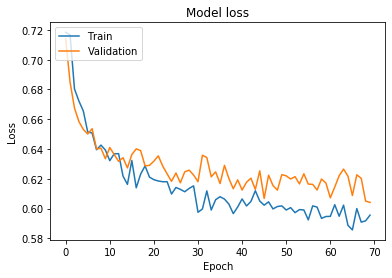

In [80]:
#Plotting results, after training model
plt.plot(image_classifier_model.history['loss'])
plt.plot(image_classifier_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [79]:
#Plotting results, after training model
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Validation'], loc = 'upper left')
#plt.show()

In [115]:
# Testing Performance of Image Classifier on Testing Data
# Hatchback Images

directory1 = r'Test_CarImages/Hatchback'
directory2 = r'Test_CarImages/Sedan'

number_hatchback_test_examples = len(os.listdir(directory1)) # This should be equal to 93
number_sedan_test_examples = len(os.listdir(directory2))
print("Hatch", number_hatchback_test_examples)
print("Sed", number_sedan_test_examples)
print("Total Number Test Examples", number_hatchback_test_examples + number_sedan_test_examples)

Hatch 93
Sed 93
Total Number Test Examples 186


In [110]:
# Hatchbacks Test
directory1 = r'Test_CarImages/Hatchback'

correct_hatchback_prediction = 0
incorrect_hatchback_prediction = 0
number_hatchback_test_examples = len(os.listdir(directory1)) # This should be equal to 93

i = 0 # Initialising i
while i < number_hatchback_test_examples: # For number of images in the directory
    #print("In While Loop")
    for jpg_image in os.listdir(directory1): # For all these images
        print("In first Loop")
        if jpg_image.endswith(".jpg") or filename.endswith(".png"):
            #print("Second Loop Loop")
            test_hatchback_id = os.listdir(directory1)[i]
            #print(i,jpg_image)
            test_hatchback_path = os.path.join(directory1, test_hatchback_id)
            test_hatchback_image = load_image(test_hatchback_path)
            #tf.keras.preprocessing.image.load_img(test_hatchback_path, target_size = (224,224))
            pred_as_list1 = model.predict(test_hatchback_image).tolist() # converting prediction to list
            prediction1 = pred_as_list1[0].index(max(pred_as_list1[0])) # 0 or 1, if 0 this means hatchback, based on order of image folders in CarImages folder
            if prediction1 == 0:
                correct_hatchback_prediction += 1 # Incrementing the count based on correct predictions
                i += 1
            else:
                incorrect_hatchback_prediction +=1
                i += 1
                
hatchback_test_accuracy = correct_hatchback_prediction/number_hatchback_test_examples
print("Hatchback test accuracy", hatchback_test_accuracy)
print("correct_hatchback_prediction", correct_hatchback_prediction)
print("incorrect_hatchback_prediction", incorrect_hatchback_prediction)

In While Loop
In first Loop
Second Loop Loop
0 015fa8ca63.jpg
In first Loop
Second Loop Loop
1 03c40450c9.jpg
In first Loop
Second Loop Loop
2 045bd97825.jpg
In first Loop
Second Loop Loop
3 06f960c228.jpg
In first Loop
Second Loop Loop
4 09a9bcef0c.jpg
In first Loop
Second Loop Loop
5 09fac1c4f5.jpg
In first Loop
Second Loop Loop
6 11a67dece6.jpg
In first Loop
Second Loop Loop
7 17cb492cd7.jpg
In first Loop
Second Loop Loop
8 19d5109503.jpg
In first Loop
Second Loop Loop
9 19efe06275.jpg
In first Loop
Second Loop Loop
10 1da0983e1d.jpg
In first Loop
Second Loop Loop
11 1eb8ff75f2.jpg
In first Loop
Second Loop Loop
12 1f892925cc.jpg
In first Loop
Second Loop Loop
13 20c5979cc2.jpg
In first Loop
Second Loop Loop
14 20fd8c9b5d.jpg
In first Loop
Second Loop Loop
15 21be55679b.jpg
In first Loop
Second Loop Loop
16 22ffe88fc0.jpg
In first Loop
Second Loop Loop
17 23f09da7ce.jpg
In first Loop
Second Loop Loop
18 24d21d9b1d.jpg
In first Loop
Second Loop Loop
19 24d47a90cb.jpg
In first Loop
Se

In [111]:
# Testing Performance of Image Classifier on Testing Data
# Sedan Images

directory2 = r'Test_CarImages/Sedan'

correct_sedan_prediction = 0
incorrect_sedan_prediction = 0
number_sedan_test_examples = len(os.listdir(directory2)) # This should be equal to 93

i = 0 
while i < number_sedan_test_examples:
    #print("In While Loop")
    for jpg_image in os.listdir(directory2):
        #print("In first Loop")
        if jpg_image.endswith(".jpg") or filename.endswith(".png"):
            #print("Second Loop Loop")
            test_sedan_id = os.listdir(directory2)[i]
            #print(i,jpg_image)
            test_sedan_path = os.path.join(directory2, test_sedan_id)
            test_sedan_image = load_image(test_sedan_path)
            #tf.keras.preprocessing.image.load_img(test_hatchback_path, target_size = (224,224))
            pred_as_list2 = model.predict(test_sedan_image).tolist() 
            prediction2 = pred_as_list2[0].index(max(pred_as_list2[0])) # 0 or 1, if 1 this means sedan
            if prediction2 == 1:
                correct_sedan_prediction += 1
                i += 1
            else:
                incorrect_sedan_prediction +=1
                i += 1
                
sedan_test_accuracy = correct_sedan_prediction/number_sedan_test_examples
print("Sedan test accuracy", sedan_test_accuracy)
print("correct_sedan_prediction", correct_sedan_prediction)
print("incorrect_sedan_prediction", incorrect_sedan_prediction)


In While Loop
In first Loop
Second Loop Loop
0 02efa962e1.jpg
In first Loop
Second Loop Loop
1 05b42ff965.jpg
In first Loop
Second Loop Loop
2 07fa9d2167.jpg
In first Loop
Second Loop Loop
3 08b0ee0d4f.jpg
In first Loop
Second Loop Loop
4 0a5c79c24b.jpg
In first Loop
Second Loop Loop
5 0a5f73449c.jpg
In first Loop
Second Loop Loop
6 0abb848d85.jpg
In first Loop
Second Loop Loop
7 0acc646e06.jpg
In first Loop
Second Loop Loop
8 0bacedb4af.jpg
In first Loop
Second Loop Loop
9 0bbbe110b4.jpg
In first Loop
Second Loop Loop
10 0d69d0e4b8.jpg
In first Loop
Second Loop Loop
11 0da821828a.jpg
In first Loop
Second Loop Loop
12 0ed1c090f9.jpg
In first Loop
Second Loop Loop
13 1a736ad22f.jpg
In first Loop
Second Loop Loop
14 1b4d752b4f.jpg
In first Loop
Second Loop Loop
15 1b77e2a9c2.jpg
In first Loop
Second Loop Loop
16 1bc78686e7.jpg
In first Loop
Second Loop Loop
17 1dc8b48ae2.jpg
In first Loop
Second Loop Loop
18 1e96df059c.jpg
In first Loop
Second Loop Loop
19 1ed87c0c4c.jpg
In first Loop
Se

In [112]:
Total_Test_Samples = number_hatchback_test_examples + number_sedan_test_examples
Total_Correct_Predictions = correct_hatchback_prediction + correct_sedan_prediction
Overall_Model_Accuracy = (Total_Correct_Predictions/Total_Test_Samples)*100

print("Model Accuracy = ", Overall_Model_Accuracy)

Model Accuracy =  78.49462365591397


In [75]:
#sedan_image_id = os.listdir('CarImages/Sedans')[0]
#sedan_image = load_image((os.path.join('CarImages/Sedans', sedan_image_id)))

#Test model on sample images
test_sedan_id = os.listdir('Images/TestImages')[1]
test_sedan_path = os.path.join('Images/TestImages', test_sedan_id)
test_sedan_image = load_image(test_sedan_path)

test_hatchback_id = os.listdir('Images/TestImages')[0]
test_hatchback_path = os.path.join('Images/TestImages', test_hatchback_id)
test_hatchback_image = load_image(test_hatchback_path)


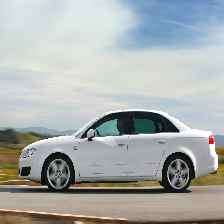

In [76]:
tf.keras.preprocessing.image.load_img(test_sedan_path, target_size = (224,224))

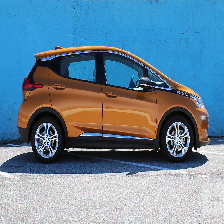

In [77]:
tf.keras.preprocessing.image.load_img(test_hatchback_path, target_size = (224,224))

In [1]:
print(model.predict(test_hatchback_image))

NameError: name 'model' is not defined

In [88]:
model.predict(test_sedan_image)[0][0]

0.26034808

In [86]:
max(model.predict(test_sedan_image))

array([0.26034808, 0.73965186], dtype=float32)

In [97]:
x = model.predict(test_sedan_image).tolist()
#x[0]
ind = x[0].index(max(x[0]))
ind

1

In [31]:
print(model.predict(test_sedan_image)) # [[Probability image is Hatchback   Probability Image is Sedan]]

[[0.7306192 0.2693808]]
